In [1]:
import math
import numpy as np
from ambiance import Atmosphere
import json
from tabulate import tabulate

In [2]:

# Defining atmospheric conditions with a function
def ambient_props(altitude_meters):
    atmosphere = Atmosphere(altitude_meters)
    rho = atmosphere.density
    nu = atmosphere.kinematic_viscosity
    T = atmosphere.temperature
    g = atmosphere.grav_accel
    return rho, nu, T, g

# Read JSON
with open("reports\wing_sizing_res.json", "r") as f:
    data = json.load(f)

# Import all the variables
altitude = 0.0 # ASL in metres 
altitide_cruise = float(data["altitude_cruise"]) # ASL in metres 
## Do not change the following ______________________:)
air = ambient_props(altitude)
rho, nu ,  T, g = air[0], air[1], air[2], air[3]
## __________________________________________________:)


In [3]:
# Global variables Horizontal tail from guess all need to be honored
pi=math.pi

# Data from wing sizing
C_REF= float(data["MAC"])        # Mean geometric chord
S_REF= float(data["S_req"])      # wing reference area
b_wing = float(data["b_req"])    # meters
AR = float(data["AR"])             # estimated from Great shark F320
alpha_0 = 0.000001
W_s = float(data["W_S"])
V_c = float(data["V"])             # Airspeed Cruise
V_s = float(data["V_s"])       # Stall Speed
V_h = V_c                    # effective airspeed at the horizontal tail region

#--------------------------------------------------------------------------------#
# The following values need to be  updated manually
alpha_f=0.0001              #  Twist angle  update this value if wing design is changed
alpha_w= 1.9                # WIng sitting angle degrees update this value if the wing is installed at an angle
#--------------------------------------------------------------------------------#
V_H = 0.7                # 0.5 - 1.0 (0.7 for GA single engine) it was 0.5
V_V = 0.04                  # 0.03 - 0.08 (0.04 for GA single engine)
D_f = 0.2                   # estimated obtained from aerodynamics
K_C = 1.2                     # ranges from 1 to 1.4 it's the fuse correction factor page 300 pdf
Sweep= 0                    # 8 degress estimated from Great shark F320
#------------------ Trimming paramets--------------------------------------# 
C_mo_wf = -0.109         # wing pitching moment coefficient f
C_m_af = -0.013            # airfoil section pitching moment coefficient
alpha_t= 0.0000             # twist angle
etha_h = 0.95               # Goes from 0.85 to 0.95 page 276 book

# Parameters  Used to calculate the horizontal tail desired lift coefficient at cruise REVISE ALL!!!
h = 0                       # aircraft center of gravity
l_L = 0.45                  # lateral trim coefficient from table 6.2
h_o= 0.25                   # The aerodynamic center of the wing/fuselage combination is located at 
                            # 23% of MAC
#cg_p = 0.32 # aircraft center of gravity is located at 32% of the fuselage length
cg_d = 0.033                #!!! Assuming that the aircraft cg is 3.3 cm ahead of the wing/fuselage 
                            #aerodynamic center. I INVENTED THIS VALUE !!!!!
error_tolerance = 0.001     # Tolerance for the error
N = 9                       # (number of segments-1)

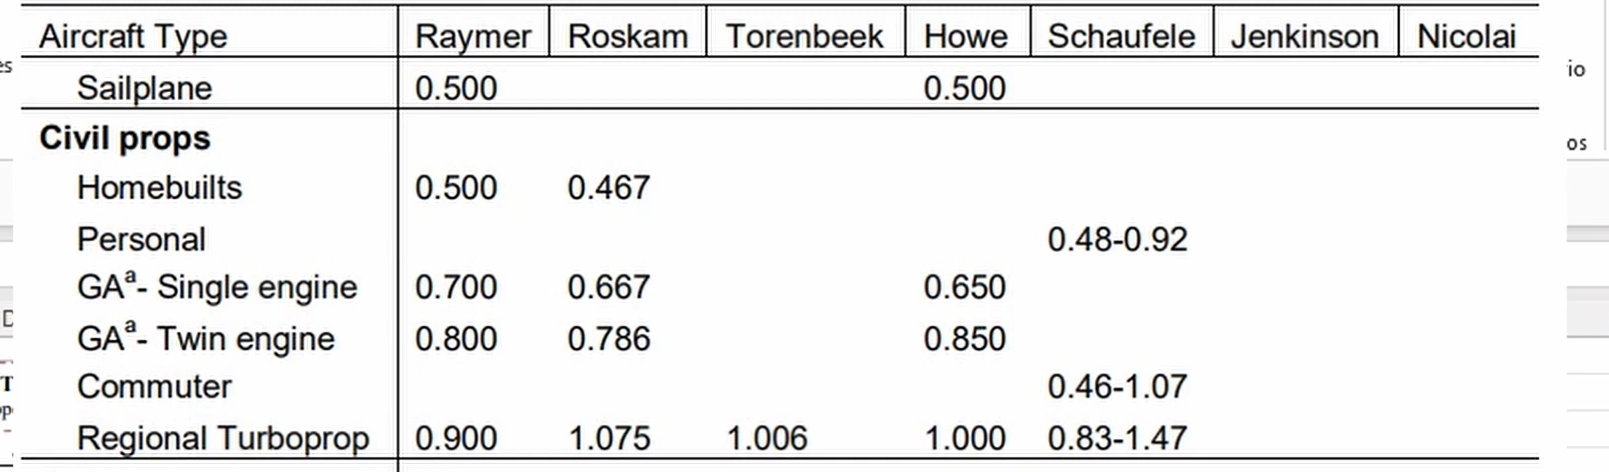

Horizontal Tail sizing
1. Select horizontal tail volume coefficient, V_H (Table 6.4).
2. Calculate optimum tail moment arm (l_opt) to minimize the aircraft drag and weight (Section 6.6).
3. Calculate horizontal tail planform area, S_h (Equation (6.24)).
6. Calculate wing/fuselage aerodynamic pitching moment coefficient C_mo_wf (Equation (6.26)).



In [4]:
L_opt = K_C*(np.sqrt((4*C_REF*S_REF*V_H)/(pi*D_f)))
#rint("Optimum tail moment arm =", L_opt)
S_h= (V_H*S_REF*C_REF)/(L_opt)
#print("Tail plataform area =", S_h)
#C_mo_wf = C_m_af*((AR*((np.cos((math.radians(Sweep))))*(np.cos((math.radians(Sweep))))))/(AR+(2*(np.cos((math.radians(Sweep)))))))+(0.01*alpha_t) # from xflr5 at cruise 0aoa wing gives -0.368
##print("Wing ptching moment coefficient =", C_mo_wf)


7. Calculate cruise lift coefficient, C_L_c (Equation (6.27)).
8. Calculate horizontal tail desired lift coefficient at cruise from trim (Equation (6.29)).

In [5]:
rho_ac = ambient_props(altitide_cruise)[0]
C_L_c_w=(2*(W_s))/(rho_ac*(V_c**2))
print("Cruise lift coefficient =", C_L_c_w)
L_f = L_opt/l_L # Finding h-ho from trim equation -- needs to be refines
#print ("Fuselage lenght = ", L_f , "m")
#X_appex = (-h_o*C_REF )+ (cg_p*L_f)+cg_d
h = (h_o*C_REF) - cg_d   
C_L_h_Opt = (C_mo_wf+(C_L_c_w*(h-h_o)))/(etha_h*V_H)# MOST IMPORTANT EQUATION IN TAIL DESIGN !!!! equation 6.29
#print ("Horizontal tail desired lift coefficient = ",C_L_h_Opt)

Cruise lift coefficient = [0.93953574]


In [6]:
AR_h = (2*AR/3)
Taper_h=1# Initially this should match the wing taper ratio
Sweept_h=0.0000 # Initially this should match the wing sweept
C_l_alpha_h = 6.239746# data from airfoil
C_L_alpha = C_l_alpha_h/(1+(C_l_alpha_h/(pi*AR_h)))# Equation 6.57

alpha_h = np.rad2deg((C_L_h_Opt/C_l_alpha_h))
#print("Tail angle of attack in cruise =",alpha_h,"degrees")

9. Using thin airfoil theory check if tail is providing enough lift

In [7]:
# Data for employing the lifting line theory calculate the tail lift coefficient using the obtained angle of attack
#print("Horizontal tail surface area =",S_h) 
#print("Horizontal tail aspect ratio =",AR_h)
#print("Horizontal tail aspect ratio =",Taper_h)
#print("Airfoil lift curve slope",C_l_alpha_h )
#print("Horixontal tail twist angle =",alpha_t)
#print("Horizontal tail estimated angle of attack =",alpha_h)
#print("Zero anlge of attack =",alpha_0)


In [8]:

b_h = np.sqrt(AR_h * S_h)  # Update the variable name
theta = np.linspace(np.pi / (2 * N), np.pi / 2, N)
alpha = alpha_h + alpha_t - np.linspace(0, alpha_t, N)
z = (b_h / 2) * np.cos(theta)
c = C_REF * (1 - (1 - Taper_h) * np.cos(theta))  # Mean Aerodynamic Chord at each segment
mu = c * C_l_alpha_h / (4 * b_h)
LHS = mu * (np.deg2rad(alpha) - np.deg2rad(alpha_0))
B = np.zeros((N, N))
A = np.zeros(N)
for i in range(N):
    for j in range(N):
        B[i, j] = np.sin((2 * j - 1) * theta[i]) * (1 + (mu[i] * (2 * j - 1)) / np.sin(theta[i]))
A = np.linalg.solve(B, LHS)
sum1 = np.zeros(N)
sum2 = np.zeros(N)

for i in range(N):
    for j in range(N):
        sum1[i] += (2 * j - 1) * A[j] * np.sin((2 * j - 1) * theta[i])
        sum2[i] += A[j] * np.sin((2 * j - 1) * theta[i])
CL_tail = np.pi * AR_h * A[0]  # Update the variable name
if abs(CL_tail)>  abs(C_L_h_Opt):
    print("Horizontal tail lift coefficient =", CL_tail, "& Required coefficient is", C_L_h_Opt, "So your tail is providing enough lift")
else:
    print("You are not providing enough lift; try changing your tail angle")


Horizontal tail lift coefficient = -0.7880587922714316 & Required coefficient is [-0.46956618] So your tail is providing enough lift


10. We now need to take into account the downwash effects from the wing

In [9]:
e_o = (2*C_L_c_w)/(pi*AR)
deltha_e_deltha_a = (2*C_L_alpha)/(pi*AR)
e=e_o+(deltha_e_deltha_a*np.deg2rad(alpha_w))
i_h= alpha_h-alpha_f+np.rad2deg(e)


In [10]:
b_h = np.sqrt(AR_h * S_h)
C_h = b_h/AR_h
C_h_root=(3*C_h/2)/((1+Taper_h+(Taper_h**2))/(1+Taper_h))
C_h_tip = Taper_h* C_h_root
"""
print("The final dimension of the Horizontal tail are:")
print("Spam = {0:1.5f}".format(b_h), "m")
print("MAC = {0:1.5f}".format(C_h), "m")
print("Root chord = {0:1.5f}".format(C_h_root), "m")
print("Tip chord = {0:1.5f}".format(C_h_tip), "m")
print("Surface area = {0:1.5f}".format(S_h), "m^2")
print("Aspect ratio = {0:1.5f}".format(AR_h), "")
print("Tail setting angle = {0:1.5f}".format(*i_h), "degrees")
print("Airfoil = S9032 (9%)")
"""

'\nprint("The final dimension of the Horizontal tail are:")\nprint("Spam = {0:1.5f}".format(b_h), "m")\nprint("MAC = {0:1.5f}".format(C_h), "m")\nprint("Root chord = {0:1.5f}".format(C_h_root), "m")\nprint("Tip chord = {0:1.5f}".format(C_h_tip), "m")\nprint("Surface area = {0:1.5f}".format(S_h), "m^2")\nprint("Aspect ratio = {0:1.5f}".format(AR_h), "")\nprint("Tail setting angle = {0:1.5f}".format(*i_h), "degrees")\nprint("Airfoil = S9032 (9%)")\n'

XFLR5 TAIL POSITION
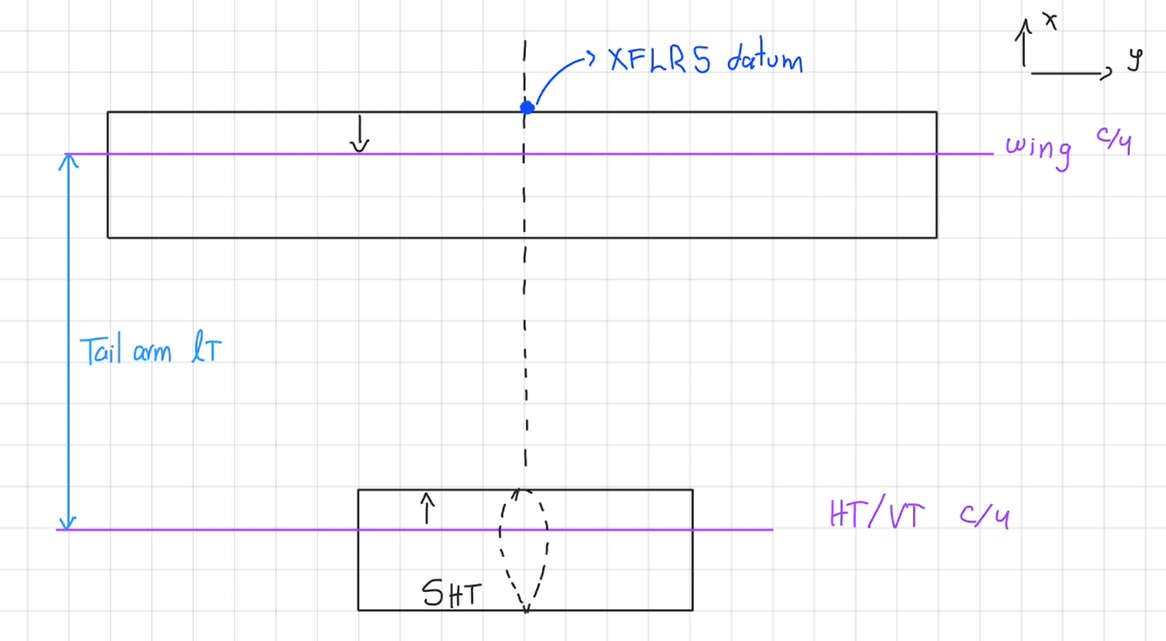

In [11]:
xtail_l = (0.25*C_REF)+L_opt-(0.25*C_h)
#print('Distance to be used on XFLR5 = ',xtail_l)

Neutral point calcualtion
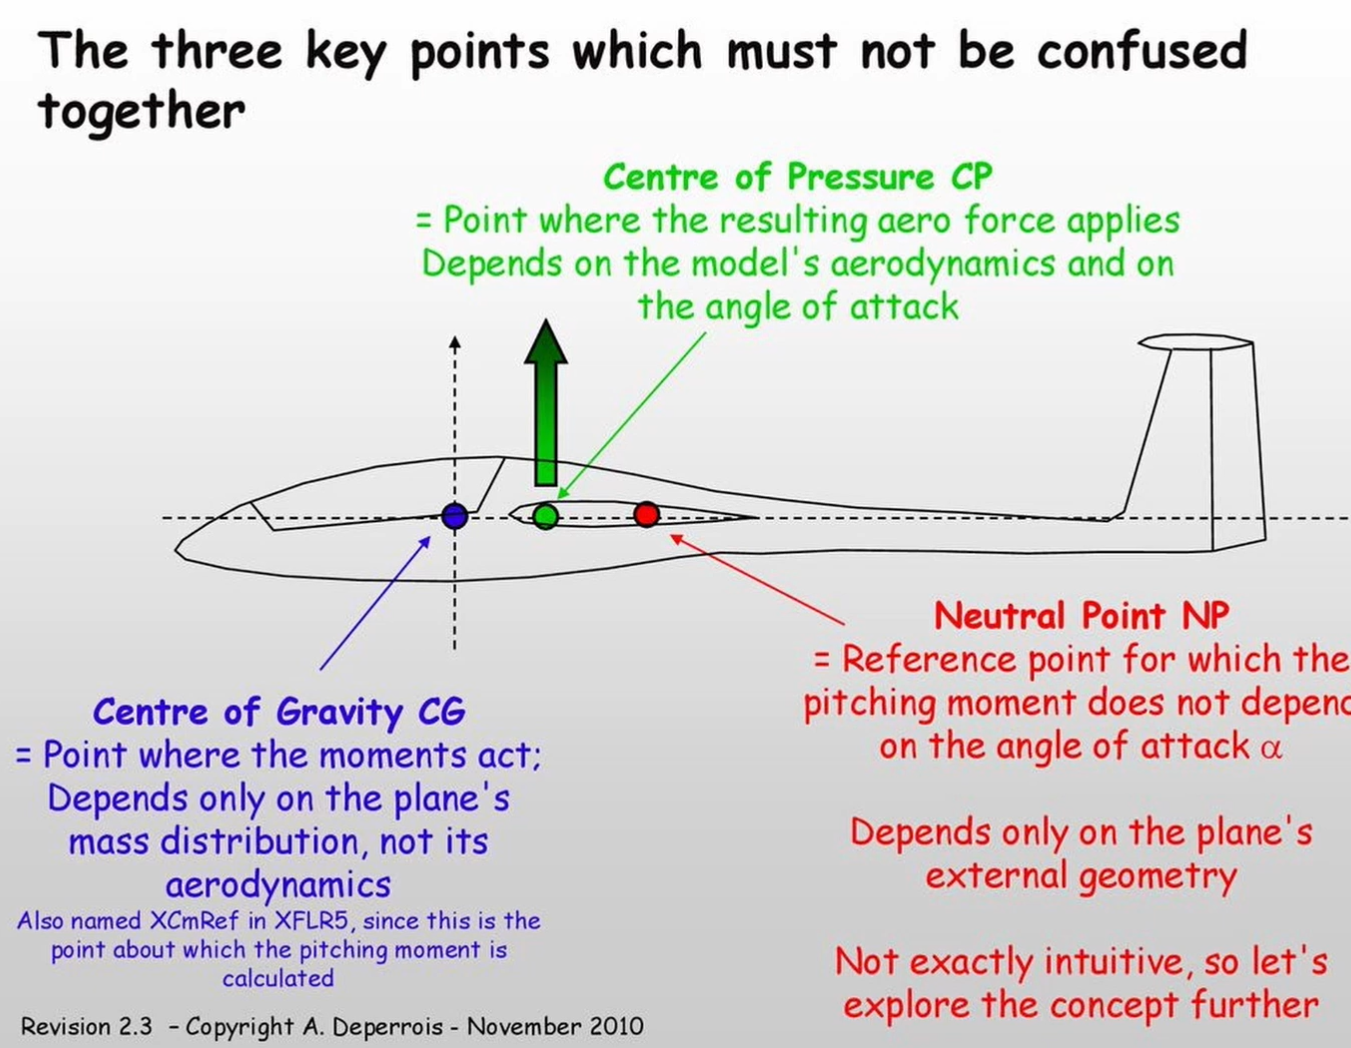

Neutral point determination
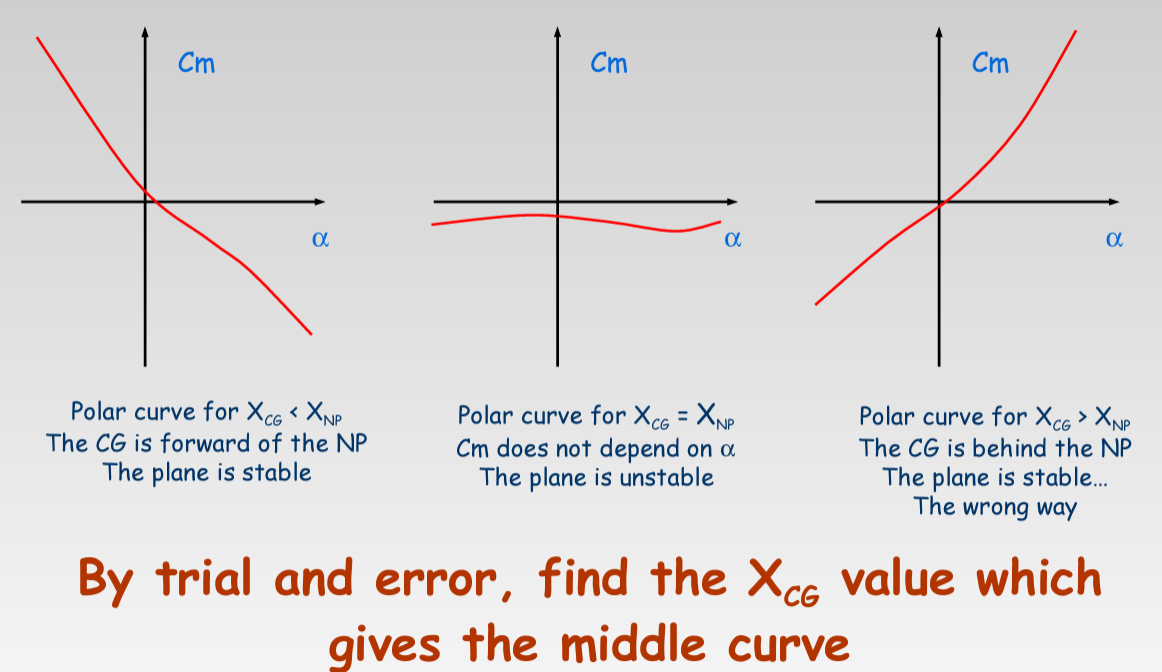

In [12]:
delta = 0

# Loop until delta reaches 1
while delta <= 3:
    Xcg_aft = (0.25 * C_REF) + (delta * 0.25 * C_REF)
    #print('Neutral point from LE=', Xcg_aft)
    
    # Increase delta by 0.2 in each iteration
    delta += 0.2


CG fwd limit

In [13]:
delta_2 = 0

while delta_2 <= 1:
    Xcg_fwd = (0.25 * C_REF) - (delta_2 * 0.25 * C_REF)
    #print('Maximum fwd xcg position = ', Xcg_fwd)
    delta_2 += 0.2





Vertical tail sizing using volume method
Data:

In [14]:
l_V = L_opt#Value taken from "optimum tail moment arm" in horizontal tail doc 
C_v_root=C_h_tip
#print(C_v_root)

In [15]:
S_V_total = (b_wing*S_REF*V_V)/l_V 
S_V_each = S_V_total/2
print("Each vertical Tail Planform Area =", S_V_each, "m^2")
C_v = C_v_root # since not taper will be used
C_v_tip = C_v_root
Taper_v = C_v_tip/C_v_root
b_v = S_V_each/C_v_root
AR_v = b_v/C_v

In [16]:
#print(" ")
#print("================================================================================================")
#print("RESULTS FROM TAIL SIZING NOTEBOOK")
#print(" ")
#print("------------------------------------------------------------------------------------------------")
#print("The final dimension of the Horizontal tail are:")
#print("Spam = {0:1.5f}".format(b_h), "m")
#print("MAC = {0:1.5f}".format(C_h), "m")
#print("Root chord = {0:1.5f}".format(C_h_root), "m")
#print("Tip chord = {0:1.5f}".format(C_h_tip), "m")
#print("Surface area = {0:1.5f}".format(S_h), "m^2")
#print("Aspect ratio = {0:1.5f}".format(AR_h), "")
#print("Tail setting angle = {0:1.5f}".format(*i_h), "degrees")
#print("Airfoil = S9032 (9%)")
#print(" ")
#print("------------------------------------------------------------------------------------------------")
#print("The final dimension of one vertical tail are:")
#print("Spam = {0:1.5f}".format(b_v), "m")
#print("MAC = {0:1.5f}".format(C_v), "m")
#print("Root chord = {0:1.5f}".format(C_v_root), "m")
#print("Tip chord = {0:1.5f}".format(C_v_tip), "m")
#print("Surface area = {0:1.5f}".format(S_V_each), "m^2")
#print("Aspect ratio = {0:1.5f}".format(AR_v), "")
#print("Airfoil = S9032 (9%)")
#print("================================================================================================")

V tail sizing

In [17]:
m_to = float(data["m_to"])
S_VT = S_h+(2*S_V_each)
betha = np.rad2deg(np.arctan(np.sqrt((2*S_V_each)/S_h))) #radians
betha_z = (np.arctan(np.sqrt((2*S_V_each)/S_h))) #radians
#VT_volume=((L_opt*S_h*(np.cos(betha)*(np.cos(betha))))/(C_REF*S_REF))
#L_opt_vt= K_C*(np.sqrt((4*C_REF*S_REF*VT_volume)/(pi*D_f)))
L_opt_vt=L_opt
xvtail_l = (0.25*C_REF)+L_opt_vt-(0.25*C_h)
AR_VT = (2*AR/3)
b_VT=np.sqrt(AR_VT*S_VT)
C_VT=(b_VT/AR_VT)
z_position = np.sin(betha_z)*0.5*b_VT
"""
print("------------------------------------------------------------------------------------------------")
print(" ")
print("The final dimension of the Inverted V_tail are:")
print("Span = {0:1.5f}".format(b_VT), "m")
print("Distance for quarter chord wing to quarter chord tail= {0:1.5f}".format(L_opt_vt), "m")
print("Distance for XFLR5 = {0:1.5f}".format(xvtail_l,"m"))
print("MAC = {0:1.5f}".format(C_VT), "m")
print("Surface area = {0:1.5f}".format(S_VT), "m^2")
print("Aspect ratio = {0:1.5f}".format(AR_VT), "")
print("V-Tail angle = {0:1.5f}".format(betha), "degrees")
print("Z positio correction = {0:1.5f}".format(z_position), "m")
print("Airfoil = E186 (10.27%)")
print(" ")
print("------------------------------------------------------------------------------------------------")
"""

NameError: name 'S_V_each' is not defined

## Write results to text file

In [ ]:
# READ CURRENT DATA FILE NAME
with open("reports/output_file_name.json", "r") as json_file:
    output_file_name = json.load(json_file)

m_to = float(data["m_to"])
air_cruise = ambient_props(altitide_cruise)


In [ ]:
from_requirements = [
    ["MTOW", "{0:1.5f}".format(m_to), "kg"],
    ["Cruise Speed", "{0:1.5f}".format(V_c), "m^2"],
    ["Stall Speed", "{0:1.5f}".format(V_s), "m^2"],
]


air_props_cruise = [
    ["Cruise Altitude", "{0:1.5f}".format(altitide_cruise), "m"],
    ["Density", ambient_props(altitide_cruise)[0], "kg/m^3"],
    ["Temperature", ambient_props(altitide_cruise)[2], "k"],
    ["Kinematic Viscosity", ambient_props(altitide_cruise)[1], "m^2/s"],
]


wing_data = [
    ["Span", "{0:1.5f}".format(b_wing), "m"],
    ["MAC", "{0:1.5f}".format(C_REF), "m"],
    ["Root chord", "{0:1.5f}".format(C_REF), "m"],
    ["Tip chord", "{0:1.5f}".format(C_REF), "m"],
    ["Surface area", "{0:1.5f}".format(S_REF), "m^2"],
    ["Aspect ratio", "{0:1.5f}".format(AR), ""],
    ["Tail setting angle", "{0:1.5f}".format(alpha_w), "degrees"],
    ["Airfoil", "fx 63-137 (13.7%)"]
]

# Define the data for the horizontal tail
v_tail_data = [
    ["Tail Arm Length", "{0:1.5f}".format(L_opt), "m"],
    ["Span", "{0:1.5f}".format(b_VT), "m"],
    ["MAC", "{0:1.5f}".format(C_VT), "m"],
    ["Surface area", "{0:1.5f}".format(S_VT), "m^2"],
    ["Aspect ratio", "{0:1.5f}".format(AR_VT), ""],
    ["Z position correction", "{0:1.5f}".format(z_position), "m"],
    ["Airfoil", "E186 (10.27%)"]
]

# Create tabulated output for each section
from_requirements = tabulate(from_requirements, headers=["Parameter", "Value", "Unit"], tablefmt="tsv")
air_props_cruise = tabulate(air_props_cruise, headers=["Parameter", "Value", "Unit"], tablefmt="tsv")
wing_table = tabulate(wing_data, headers=["Parameter", "Value", "Unit"], tablefmt="tsv")
v_tail_data = tabulate(v_tail_data, headers=["Parameter", "Value", "Unit"], tablefmt="tsv")

# Save the tabulated output to a text file
with open(output_file_name, "a") as f:
    f.write("The following requirements are used for this analysis: \n")
    f.write(from_requirements)
    f.write("\n\n")
    f.write("The air properties at cruise altitude: \n")
    f.write(air_props_cruise)
    f.write("\n\n")
    f.write("Wing Data: \n")
    f.write(wing_table)
    f.write("\n\n")
    f.write("Inverted V Tail Data:\n")
    f.write(v_tail_data)
    f.write("\n\n")